In [1]:
import pandas as pd
import numpy as np

In [2]:
import nltk
import re
import string
import contractions
import collections
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [5]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [6]:
import utils as u

In [7]:
stop_words = nltk.corpus.stopwords.words('english')

### Dataset is a portion of the Tweets surrounding past storms

In [8]:
df_full = pd.read_csv('ORIGINAL_LABELED/all_hurricanes_tweets_train.csv')
# df_full = pd.read_csv('YEARS_PRIOR_LABELED/test_with_labels.csv')
# df_full = pd.read_csv('https://raw.githubusercontent.com/Cameron-Grams/Team-HIT-workspace/main/hurricane/test_with_labels.csv')

In [9]:
df_full.shape

(13209, 18)

In [10]:
df = df_full[df_full['class_label'] == 'other_relevant_information']
df.shape

(2874, 18)

## Process Text

In [11]:
X_raw_text = df['text'].apply(lambda x: u.preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words))

In [12]:
# the min and max parameters will have to be adjusted

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(X_raw_text)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.030 s
n_samples: 2874, n_features: 1005


### Dimensionality reduction with SVD

In [13]:
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

LSA done in 0.108 s
Explained variance of the SVD step: 37.5%


In [14]:
lsa_2 = make_pipeline(TruncatedSVD(n_components=700), Normalizer(copy=False))
t0 = time()
X_lsa_2 = lsa_2.fit_transform(X_tfidf)
explained_variance_2 = lsa_2[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance_2 * 100:.1f}%")

LSA done in 0.949 s
Explained variance of the SVD step: 92.6%


## Model selection

In [15]:
make_km = lambda x: KMeans(
    n_clusters=x,
    max_iter=100,
    init = 'k-means++',
    n_init=5,
)

In [16]:
Sum_of_squared_distances = []
Sum_of_squared_distances_2 = []

K = range(1,15)

for k in K:
    km = make_km(k)
    km = km.fit(X_lsa)
    Sum_of_squared_distances.append(km.inertia_)
    
    km_2 = km.fit(X_lsa_2)
    Sum_of_squared_distances_2.append(km_2.inertia_)

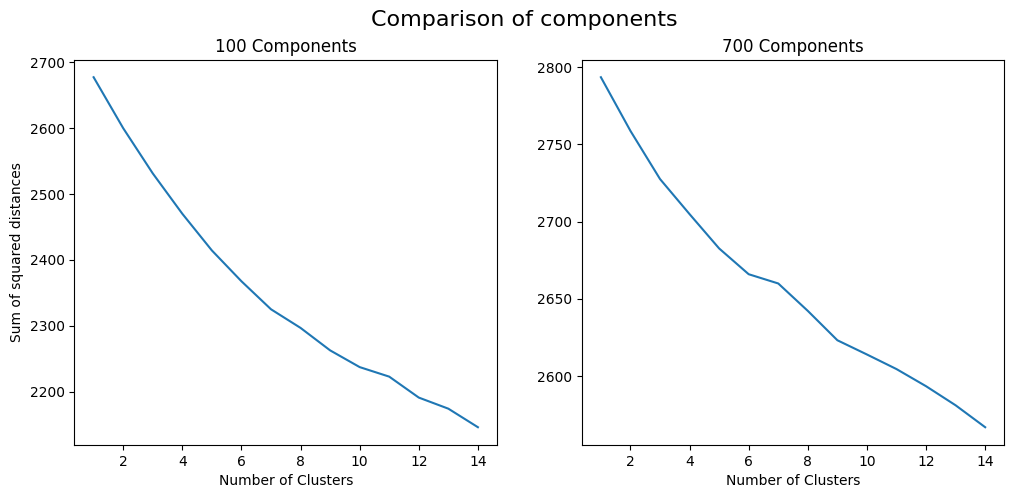

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.lineplot(x=K, y=Sum_of_squared_distances, markers=True, ax=ax1)
sns.lineplot(x=K, y=Sum_of_squared_distances_2, markers=True, ax=ax2)


fig.suptitle("Comparison of components", fontsize=16)
ax1.set_title('100 Components')
ax2.set_title('700 Components')

ax1.set_xlabel('Number of Clusters')
ax2.set_xlabel('Number of Clusters')
ax1.set_ylabel('Sum of squared distances')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
plt.show()

## Identify Clusters

In [18]:
# input the number of the elbow from the graph
num_k = 5

In [19]:
kmeans = make_km(num_k)
kmeans.fit(X_lsa_2)

KMeans(max_iter=100, n_clusters=5, n_init=5)

In [20]:
original_space_centroids = lsa_2[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :20]:
        print(f"{terms[ind]} ", end="")
    print("\n")

Cluster 0: rt hurricaneharvey hurricaneirma hurricanemaria amp water harvey food relief aid shelter thank puertorico help affect earthquak thi home peopl rain 

Cluster 1: puerto rico maria hurrican rt aid hurricanemaria rican island power food water relief http suppli peopl trump devast flood help 

Cluster 2: hurrican haiti maria matthew harvey rt relief hit affect water effort new victim devast help destruct amp impact 2010 area 

Cluster 3: flood harvey houston rt water hurricaneharvey hurrican storm victim texa tropic area amp rain home caus flash relief river texas 

Cluster 4: irma hurrican rt florida relief shelter victim water food amp storm destruct resid damag miami effort help http power caribbean 



##### 